In [2]:
import pandas as pd
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
from darts.metrics import rmse, mae
import matplotlib.pyplot as plt
import random
from pytorch_lightning.callbacks import EarlyStopping
import torch

# 1. خواندن داده
df = pd.read_excel("main_trans.xlsx")
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df = df.dropna(subset=['DateTime'])

# 2. فیلتر بازه زمانی
target_date = pd.to_datetime('2023-9-01 00:00:00')
df_filtered = df[df['DateTime'] >= target_date]

# 3. بازنمونه‌گیری و پر کردن داده‌های خالی
df_filtered = df_filtered.set_index('DateTime').resample('1H').mean()
df_filtered = df_filtered.interpolate(method='linear')

# 4. ساخت سری هدف و covariates
series = TimeSeries.from_dataframe(df_filtered, value_cols='oil temperature', freq='h')
covariates = TimeSeries.from_dataframe(df_filtered, value_cols=['winding temperature', 'tap position'], freq='h')

# 5. نرمال‌سازی
scaler_series = Scaler(MinMaxScaler())
series_scaled = scaler_series.fit_transform(series)

scaler_cov = Scaler(MinMaxScaler())
covariates_scaled = scaler_cov.fit_transform(covariates)

# 6. تقسیم داده‌ها به train, val, test
train_ratio = 0.8
val_ratio = 0.1
train_series, temp_series = series_scaled.split_after(train_ratio)
val_series, test_series = temp_series.split_after(val_ratio / (1 - train_ratio))
train_cov, temp_cov = covariates_scaled.split_after(train_ratio)
val_cov, test_cov = temp_cov.split_after(val_ratio / (1 - train_ratio))

# 7. تعریف فضای پارامترها برای random search
param_space = {
    'input_chunk_length': [24, 48, 72],
    'output_chunk_length': [6, 12, 24],
    'num_layers': [2, 4, 6],
    'layer_widths': [256, 512, 1024]
}

n_trials = 5
best_model = None
best_params = None
best_val_rmse = float('inf')

# 8. Random Search
for trial in range(n_trials):
    params = {k: random.choice(v) for k, v in param_space.items()}
    print(f"\n🔍 Trial {trial+1}/{n_trials} - Testing params: {params}")

    pl_trainer_kwargs = {
        "callbacks": [EarlyStopping(monitor="val_loss", patience=5, mode="min")],
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        "devices": 1
    }

    model = NBEATSModel(
        input_chunk_length=params['input_chunk_length'],
        output_chunk_length=params['output_chunk_length'],
        n_epochs=10,
        num_stacks=30,
        num_blocks=3,
        num_layers=params['num_layers'],
        layer_widths=params['layer_widths'],
        batch_size=32,
        random_state=42,
        model_name=f"oil-temp-nbeats-trial{trial+1}",
        pl_trainer_kwargs=pl_trainer_kwargs
    )

    model.fit(
        series=train_series,
        past_covariates=train_cov,
        val_series=val_series,
        val_past_covariates=val_cov,
        verbose=False
    )

    pred_val = model.predict(
        n=len(val_series),
        series=train_series,
        past_covariates=train_cov[-params['input_chunk_length']:].append(val_cov)
    )

    pred_val = scaler_series.inverse_transform(pred_val)
    val_series_orig = scaler_series.inverse_transform(val_series)
    val_rmse = rmse(val_series_orig, pred_val)
    print(f"📊 Validation RMSE: {val_rmse:.2f}")

    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_model = model
        best_params = params

# 9. نمایش بهترین مدل
print(f"\n✅ Best params: {best_params}")
print(f"✅ Best validation RMSE: {best_val_rmse:.2f}")

# 10. پیش‌بینی روی تست
required_covariates_length = len(train_series) + len(val_series) + len(test_series)
if len(covariates_scaled) < required_covariates_length:
    raise ValueError("طول covariates کافی نیست.")

pred = best_model.predict(
    n=len(test_series),
    series=train_series.append(val_series),
    past_covariates=covariates_scaled[:required_covariates_length]
)

pred = scaler_series.inverse_transform(pred)
test_series = scaler_series.inverse_transform(test_series)

print(f"🧪 Test RMSE: {rmse(test_series, pred):.2f}")
print(f"🧪 Test MAE: {mae(test_series, pred):.2f}")

# 11. رسم یک روز از تست
df_test = pd.DataFrame({'oil temperature': test_series.values().flatten()}, index=test_series.time_index)
df_pred = pd.DataFrame({'oil temperature': pred.values().flatten()}, index=pred.time_index)

start_time = df_test.index[0].replace(hour=0, minute=0, second=0)
end_time = start_time + pd.Timedelta(hours=23)

df_test_day = df_test[(df_test.index >= start_time) & (df_test.index <= end_time)]
df_pred_day = df_pred[(df_pred.index >= start_time) & (df_pred.index <= end_time)]

plt.figure(figsize=(6, 3))
plt.plot(df_test_day.index, df_test_day['oil temperature'], label='Actual', color='blue')
plt.plot(df_pred_day.index, df_pred_day['oil temperature'], label='Predicted', color='orange')
plt.legend()
plt.title(f"Actual vs Predicted Oil Temperature\n{start_time.date()} 00:00 to 23:00")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-1796930854.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_filtered = df_filtered.set_index('DateTime').resample('1H').mean()



🔍 Trial 1/5 - Testing params: {'input_chunk_length': 24, 'output_chunk_length': 6, 'num_layers': 4, 'layer_widths': 512}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
from darts.metrics import rmse, mae
import matplotlib.pyplot as plt
import random
from pytorch_lightning.callbacks import EarlyStopping
import torch

In [3]:
# !pip install darts

In [4]:
# 1. خواندن داده
df = pd.read_excel("main_trans.xlsx")
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df = df.dropna(subset=['DateTime'])

In [5]:
# 2. فیلتر بازه زمانی
target_date = pd.to_datetime('2023-9-01 00:00:00')
df_filtered = df[df['DateTime'] >= target_date]

In [6]:
# 3. بازنمونه‌گیری و پر کردن داده‌های خالی
df_filtered = df_filtered.set_index('DateTime').resample('1H').mean()
df_filtered = df_filtered.interpolate(method='linear')

/tmp/ipython-input-4011370313.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_filtered = df_filtered.set_index('DateTime').resample('1H').mean()


In [7]:
# 4. ساخت سری هدف و covariates
series = TimeSeries.from_dataframe(df_filtered, value_cols='oil temperature', freq='h')
covariates = TimeSeries.from_dataframe(df_filtered, value_cols=['winding temperature', 'tap position'], freq='h')

In [8]:
# 5. نرمال‌سازی
scaler_series = Scaler(MinMaxScaler())
series_scaled = scaler_series.fit_transform(series)

scaler_cov = Scaler(MinMaxScaler())
covariates_scaled = scaler_cov.fit_transform(covariates)

In [9]:
# 6. تقسیم داده‌ها به train, val, test
train_ratio = 0.8
val_ratio = 0.1
train_series, temp_series = series_scaled.split_after(train_ratio)
val_series, test_series = temp_series.split_after(val_ratio / (1 - train_ratio))
train_cov, temp_cov = covariates_scaled.split_after(train_ratio)
val_cov, test_cov = temp_cov.split_after(val_ratio / (1 - train_ratio))

In [10]:
# تعریف فضای پارامترها برای random search
param_space = {
    'input_chunk_length': [24, 48, 72],
    'output_chunk_length': [6, 12, 24],
    'num_layers': [2, 4, 6],
    'layer_widths': [256, 512, 1024]
}

In [11]:
# تعداد آزمون‌های random search
n_trials = 5

best_model = None
best_params = None
best_val_rmse = float('inf')

In [12]:
# 7. Random Search برای تیونینگ
for _ in range(n_trials):
    # انتخاب random پارامترها
    params = {k: random.choice(v) for k, v in param_space.items()}
    print(f"Testing params: {params}")

    # ساخت مدل با early stopping
    pl_trainer_kwargs = {
        "callbacks": [EarlyStopping(monitor="val_loss", patience=5, mode="min")],
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        "devices": 1
    }

    model = NBEATSModel(
        input_chunk_length=params['input_chunk_length'],
        output_chunk_length=params['output_chunk_length'],
        n_epochs=100,  # حداکثر epochs، early stopping متوقف می‌کنه
        num_stacks=30,
        num_blocks=3,
        num_layers=params['num_layers'],
        layer_widths=params['layer_widths'],
        batch_size=32,
        random_state=42,
        model_name="oil-temp-nbeats",
        pl_trainer_kwargs=pl_trainer_kwargs
    )

Testing params: {'input_chunk_length': 48, 'output_chunk_length': 6, 'num_layers': 2, 'layer_widths': 256}
Testing params: {'input_chunk_length': 72, 'output_chunk_length': 12, 'num_layers': 4, 'layer_widths': 1024}
Testing params: {'input_chunk_length': 48, 'output_chunk_length': 6, 'num_layers': 4, 'layer_widths': 512}
Testing params: {'input_chunk_length': 24, 'output_chunk_length': 12, 'num_layers': 6, 'layer_widths': 512}
Testing params: {'input_chunk_length': 24, 'output_chunk_length': 6, 'num_layers': 4, 'layer_widths': 512}


In [13]:

# 8. آموزش مدل با validation برای early stopping
model.fit(
        series=train_series,
        past_covariates=train_cov,
        val_series=val_series,
        val_past_covariates=val_cov,
        verbose=True
    )

# پیش‌بینی روی validation برای ارزیابی
pred_val = model.predict(n=len(val_series), series=train_series, past_covariates=train_cov[-params['input_chunk_length']:].append(val_cov))
pred_val = scaler_series.inverse_transform(pred_val)
val_series_orig = scaler_series.inverse_transform(val_series)

val_rmse = rmse(val_series_orig, pred_val)
print(f"Validation RMSE: {val_rmse:.2f}")

# ذخیره بهترین مدل
if val_rmse < best_val_rmse:
    best_val_rmse = val_rmse
    best_model = model
    best_params = params

print(f"Best params: {best_params}")
print(f"Best validation RMSE: {best_val_rmse:.2f}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 74.8 M | train
-------------------------------------------------------------
74.8 M    Trainable params
3.0 K     Non-trainable params
74.8 M    Total params
299.165   Total estimated model params size (MB)
1056      Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Validation RMSE: 3.13
Best params: {'input_chunk_length': 24, 'output_chunk_length': 6, 'num_layers': 4, 'layer_widths': 512}
Best validation RMSE: 3.13


In [ ]:
# محاسبه طول مورد نیاز برای covariates
required_covariates_length = len(train_series) + len(val_series) + len(test_series)

# بررسی اینکه آیا covariates کافی هستند
if len(covariates_scaled) < required_covariates_length:
    raise ValueError(f"طول covariates کافی نیست. مورد نیاز: {required_covariates_length}، موجود: {len(covariates_scaled)}")

# اجرای پیش‌بینی با covariates کامل
pred = best_model.predict(
    n=len(test_series),
    series=train_series.append(val_series),
    past_covariates=covariates_scaled[:required_covariates_length]
)

# تبدیل مقیاس خروجی‌ها
pred = scaler_series.inverse_transform(pred)
test_series = scaler_series.inverse_transform(test_series)


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# 10. ارزیابی روی test
print(f"Test RMSE: {rmse(test_series, pred):.2f}")
print(f"Test MAE: {mae(test_series, pred):.2f}")

Test RMSE: 3.46
Test MAE: 3.02


In [ ]:
# 11. تبدیل به DataFrame برای رسم
df_test = pd.DataFrame({'oil temperature': test_series.values().flatten()}, index=test_series.time_index)
df_pred = pd.DataFrame({'oil temperature': pred.values().flatten()}, index=pred.time_index)

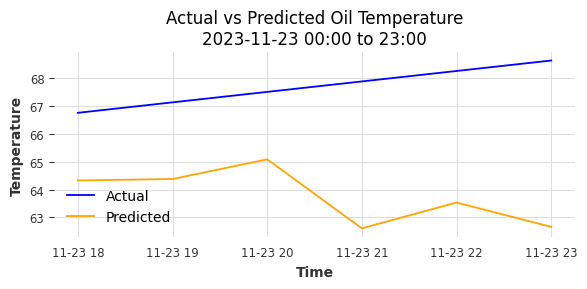

In [ ]:
# 12. رسم فقط یک روز از داده‌های تست و پیش‌بینی
start_time = df_test.index[0].replace(hour=0, minute=0, second=0)
end_time = start_time + pd.Timedelta(hours=23)

df_test_day = df_test[(df_test.index >= start_time) & (df_test.index <= end_time)]
df_pred_day = df_pred[(df_pred.index >= start_time) & (df_pred.index <= end_time)]

plt.figure(figsize=(6, 3))
plt.plot(df_test_day.index, df_test_day['oil temperature'], label='Actual', color='blue')
plt.plot(df_pred_day.index, df_pred_day['oil temperature'], label='Predicted', color='orange')
plt.legend()
plt.title(f"Actual vs Predicted Oil Temperature\n{start_time.date()} 00:00 to 23:00")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.grid(True)
plt.tight_layout()
plt.show()